In [1]:
import glob
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
from natsort import natsorted, ns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib import gridspec
import statistics

In [2]:
def read_data(receptor, ligand, time_limit=0, Verbose=False, exclusions=[]):
    data = { "Receptor":[], "Ligand":[], "Jobname":[], "Time":[], "Frame":[],
            "Interface":[], "Interface_A":[], "Interface_B":[],}
    _filein = glob.glob("/home/khlee/work/desmond/output/"+receptor+"/"+ligand+"/*/")
    _filein = natsorted(_filein, key=lambda y: y.lower())
    if Verbose:
        print(_filein)
    for i in range(len(_filein)):
        if _filein[i].split("/")[-1] in exclusions:
            continue
        try:
            t = np.loadtxt(_filein[i]+'/ene/time.dat')
            frame = list(range(1,len(t)+1))
            obs = pickle.load(open(_filein[i]+'/output/gpcr_interface.p',"rb"))
            obs_a = pickle.load(open(_filein[i]+'/output/gpcr_interface_RA.p',"rb"))
            obs_b = pickle.load(open(_filein[i]+'/output/gpcr_interface_RB.p',"rb"))
        except:
            print("Job not loaded because a file was not found: ",
                  receptor+"_"+_filein[i].split("/")[-2])
            print("\n")
            continue
        
        try:
            assert (len(t)==len(obs))
            assert (len(obs) == len(obs_a))
            assert (len(obs) == len(obs_b))
            
            temp = pd.DataFrame({"obs":obs, "obs_a":obs_a, "obs_b":obs_b, "t":t, "frame":frame})
            
            sel = list(temp[temp["t"]>=time_limit]["obs"])
            sel_a = list(temp[temp["t"]>=time_limit]["obs_a"])
            sel_b = list(temp[temp["t"]>=time_limit]["obs_b"])
            sel_t = list(temp[temp["t"]>=time_limit]["t"])
            sel_frame = list(temp[temp["t"]>=time_limit]["frame"])
            
            data["Interface"] += sel
            data["Interface_A"] += sel_a
            data["Interface_B"] += sel_b
            data["Receptor"]+=[receptor for a in range(len(sel))]
            data["Ligand"]+=[ligand for a in range(len(sel))]
            data["Jobname"]+=[receptor+"_"+_filein[i].split("/")[-2].split("_")[-1] for a in range(len(sel))]
            data["Time"]+=sel_t
            data["Frame"]+=sel_frame
        except:
            print("Job not loaded because number of datapoints mismatch: ",
                  receptor+"_"+_filein[i].split("/")[-2].split("_")[-1])
            print("Time :", len(t), "Interface: ", len(obs), "Interface_A: ", len(obs_a), "Interface_B: ", len(obs_b))
            print("\n")
            continue
    
    return pd.DataFrame(data)

def check_interface(df, receptor=None):
#     difference = []
#     ab = []
#     percent_diff = []
#     for i in range(len(df)):
#         difference.append(df["Interface"][i] - (df["Interface_A"][i] + df["Interface_B"][i]))
#         ab.append(df["Interface_A"][i] + df["Interface_B"][i])
#         percent_diff.append(abs((df["Interface"][i] - (df["Interface_A"][i] + df["Interface_B"][i]))/df["Interface"][i]
#                            *100))
    df["RAB-AB"] = abs(df["Interface"] - (df["Interface_A"]+df["Interface_B"]))
    df["AB"] = df["Interface_A"]+df["Interface_B"]
    df["%Diff"] = round(df["RAB-AB"]/df["Interface"]*100,1)
    return df

def read_caller(keywords):
    df = pd.DataFrame()
    for pair in keywords:
        df = pd.concat([df,read_data(pair[0],pair[1])])
    return df



In [3]:
sel_pairs = [("d2gi", "bro"),("d2go", "bro"),
             ("d3gi", "prm"),("d3go", "prm"),
             ("d3gi", "pd"),("d3go", "pd")]
df = read_caller(sel_pairs)
df = check_interface(df)
df

Job not loaded because a file was not found:  d3gi_output


Job not loaded because a file was not found:  d3gi_output




,Receptor,Ligand,Jobname,Time,Frame,Interface,Interface_A,Interface_B,RAB-AB,AB,%Diff
0,d2gi,bro,d2gi_bro.1,0.24,1,1469.0,1351.0,132.0,14.0,1483.0,1.0
1,d2gi,bro,d2gi_bro.1,0.48,2,1412.0,1331.0,88.0,7.0,1419.0,0.5
2,d2gi,bro,d2gi_bro.1,0.72,3,1471.0,1377.0,108.0,14.0,1485.0,1.0
3,d2gi,bro,d2gi_bro.1,0.96,4,1508.0,1390.0,130.0,12.0,1520.0,0.8
4,d2gi,bro,d2gi_bro.1,1.20,5,1449.0,1383.0,81.0,15.0,1464.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
13595,d3go,pd,d3go_pd.f6,1197.60,1996,1661.0,1602.0,59.0,0.0,1661.0,0.0
13596,d3go,pd,d3go_pd.f6,1198.20,1997,1580.0,1543.0,37.0,0.0,1580.0,0.0
13597,d3go,pd,d3go_pd.f6,1198.80,1998,1621.0,1578.0,43.0,0.0,1621.0,0.0
13598,d3go,pd,d3go_pd.f6,1199.40,1999,1558.0,1507.0,51.0,0.0,1558.0,0.0


In [4]:
df

,Receptor,Ligand,Jobname,Time,Frame,Interface,Interface_A,Interface_B,RAB-AB,AB,%Diff
0,d2gi,bro,d2gi_bro.1,0.24,1,1469.0,1351.0,132.0,14.0,1483.0,1.0
1,d2gi,bro,d2gi_bro.1,0.48,2,1412.0,1331.0,88.0,7.0,1419.0,0.5
2,d2gi,bro,d2gi_bro.1,0.72,3,1471.0,1377.0,108.0,14.0,1485.0,1.0
3,d2gi,bro,d2gi_bro.1,0.96,4,1508.0,1390.0,130.0,12.0,1520.0,0.8
4,d2gi,bro,d2gi_bro.1,1.20,5,1449.0,1383.0,81.0,15.0,1464.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
13595,d3go,pd,d3go_pd.f6,1197.60,1996,1661.0,1602.0,59.0,0.0,1661.0,0.0
13596,d3go,pd,d3go_pd.f6,1198.20,1997,1580.0,1543.0,37.0,0.0,1580.0,0.0
13597,d3go,pd,d3go_pd.f6,1198.80,1998,1621.0,1578.0,43.0,0.0,1621.0,0.0
13598,d3go,pd,d3go_pd.f6,1199.40,1999,1558.0,1507.0,51.0,0.0,1558.0,0.0


NameError: name 't' is not defined

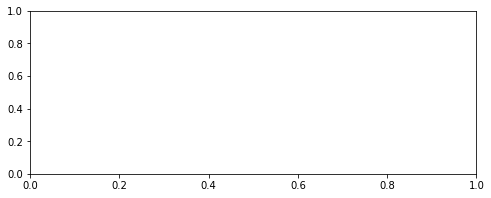

In [5]:

nrow = 1
ncol = 1
figheight = 3
figwidth = 8
linewidth = 1

fig, ax1 = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
#fig.suptitle(title, fontsize="x-large")
fig.subplots_adjust(hspace=0.05, wspace=0.1)

ax1.plot(t, RAB, label="RAB",color="red")
ax1.plot(t, AB, label="RA+RB",color="blue")
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Interface (Å)")
ax1.set_title(title)
ax1.grid(True, linestyle='dotted', linewidth=0.2)
ax1.legend(loc='upper right', frameon=False)
# ax1.set_ylim(binstr, binend)
ax1.tick_params(top=True, bottom=True, left=True, right=True,
                labelleft=True, labelbottom=True)



In [ ]:
nrow = 1
ncol = 1
figheight = 3
figwidth = 10
linewidth = 1
fig, ax1 = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
#fig.suptitle(title, fontsize="x-large")
fig.subplots_adjust(hspace=0.05, wspace=0.1)

indf = df

x_name = []
mean = []
stdev = []
color_dict = {"d2gi_bro":"blue", "d2go_bro":"red", "d3gi_prm":"cyan", "d3go_prm":"pink", "d3gi_pd":"green",
              "d3go_pd":"orange"}
ls_color = []
for job in natsorted(set(indf["Jobname"]), key=lambda y: y.lower()):
    ls_color.append(color_dict[job.split(".")[0]])
    x_name.append(job)
    indf2=indf[indf['Jobname']==job]
    mean.append(statistics.mean(indf2["RAB-AB"]))
    stdev.append(statistics.stdev(indf2["RAB-AB"]))
    

ax1.bar(x_name, mean, yerr=stdev,color=ls_color)
ax1.set_xlabel("")
ax1.set_ylabel("Interface (Å)")
ax1.set_title("Interface Difference")
ax1.grid(True, linestyle='dotted', linewidth=0.2)
ax1.legend(loc='upper right', frameon=False)
# ax1.set_ylim(binstr, binend)
ax1.tick_params(top=True, bottom=True, left=True, right=True,
                labelleft=True, labelbottom=True)

ax1.tick_params(axis='x', labelrotation = 90)



In [ ]:
nrow = 1
ncol = 1
figheight = 3
figwidth = 10
linewidth = 1
fig, ax1 = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
#fig.suptitle(title, fontsize="x-large")
fig.subplots_adjust(hspace=0.05, wspace=0.1)

indf = df

x_name = []
mean = []
stdev = []
color_dict = {"d2gi_bro":"blue", "d2go_bro":"red", "d3gi_prm":"cyan", "d3go_prm":"pink", "d3gi_pd":"green",
              "d3go_pd":"orange"}
ls_color = []
for job in natsorted(set(indf["Jobname"]), key=lambda y: y.lower()):
    ls_color.append(color_dict[job.split(".")[0]])
    x_name.append(job)
    indf2=indf[indf['Jobname']==job]
    mean.append(statistics.mean(indf2["%Diff"]))
    stdev.append(statistics.stdev(indf2["%Diff"]))
    

ax1.bar(x_name, mean, yerr=stdev,color=ls_color)
ax1.set_xlabel("")
ax1.set_ylabel("Normalized Difference (%)")
ax1.set_title("Interface Difference")
ax1.grid(True, linestyle='dotted', linewidth=0.2)
ax1.legend(loc='upper right', frameon=False)
# ax1.set_ylim(binstr, binend)
ax1.tick_params(top=True, bottom=True, left=True, right=True,
                labelleft=True, labelbottom=True)

ax1.tick_params(axis='x', labelrotation = 90)



In [ ]:
nrow = 1
ncol = 1
figheight = 3
figwidth = 10
linewidth = 1
fig, ax1 = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
#fig.suptitle(title, fontsize="x-large")
fig.subplots_adjust(hspace=0.05, wspace=0.1)

indf = df

x_name = []
mean = []
stdev = []
color_dict = {"d2gi_bro":"blue", "d2go_bro":"red", "d3gi_prm":"cyan", "d3go_prm":"pink", "d3gi_pd":"green",
              "d3go_pd":"orange"}
ls_color = []
for job in natsorted(set(indf["Jobname"]), key=lambda y: y.lower()):
    ls_color.append(color_dict[job.split(".")[0]])
    x_name.append(job)
    indf2=indf[indf['Jobname']==job]
    mean.append(statistics.mean(indf2["Interface"]))
    stdev.append(statistics.stdev(indf2["Interface"]))
    

ax1.bar(x_name, mean, yerr=stdev,color=ls_color)
ax1.set_xlabel("")
ax1.set_ylabel("Interface (Å)")
ax1.set_title("Interface")
ax1.grid(True, linestyle='dotted', linewidth=0.2)
ax1.legend(loc='upper right', frameon=False)
# ax1.set_ylim(binstr, binend)
ax1.tick_params(top=True, bottom=True, left=True, right=True,
                labelleft=True, labelbottom=True)

ax1.tick_params(axis='x', labelrotation = 90)



In [ ]:
df